Graph based conclusions: https://docs.google.com/document/d/1HR4YUYdQ3BKiC6ECeSTTuvoRRuR7up5Nezd7sdIG7EM/edit?usp=sharing

Note: Jurisdiction means city

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://opendata.maryland.gov/api/views/2p5g-xrcb/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)

# strip extra spaces from all column names
df.columns = df.columns.str.strip()
df



,JURISDICTION,COUNTY,YEAR,POPULATION,MURDER,RAPE,ROBBERY,AGG. ASSAULT,B & E,LARCENY THEFT,...,"VIOLENT CRIME RATE PERCENT CHANGE PER 100,000 PEOPLE","PROPERTY CRIME RATE PER 100,000 PEOPLE","PROPERTY CRIME RATE PERCENT CHANGE PER 100,000 PEOPLE","MURDER PER 100,000 PEOPLE","RAPE PER 100,000 PEOPLE","ROBBERY PER 100,000 PEOPLE","AGG. ASSAULT PER 100,000 PEOPLE","B & E PER 100,000 PEOPLE","LARCENY THEFT PER 100,000 PEOPLE","M/V THEFT PER 100,000 PEOPLE"
0,Galestown,Dorchester,2008,101,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Goldsboro,Caroline,2014,247,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Henderson,Caroline,1997,66,0,0,0,0,0,0,...,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Keedysville,Washington,1990,464,0,0,0,0,2,2,...,NaN,862.1,NaN,0.0,0.0,0.0,0.0,431.1,431.1,0.0
4,Kitzmiller,Garrett,1996,275,0,0,0,0,0,0,...,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,Woodsboro,Frederick,2016,1185,0,0,0,0,0,0,...,-100.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4280,Woodsboro,Frederick,2017,1185,0,0,0,1,1,0,...,84.4,84.4,84.4,0.0,0.0,0.0,84.4,84.4,0.0,0.0
4281,Woodsboro,Frederick,2018,1240,0,0,0,1,0,1,...,-4.4,80.6,-4.4,0.0,0.0,0.0,80.6,0.0,80.6,0.0
4282,Woodsboro,Frederick,2019,1240,0,0,0,0,0,0,...,-100.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


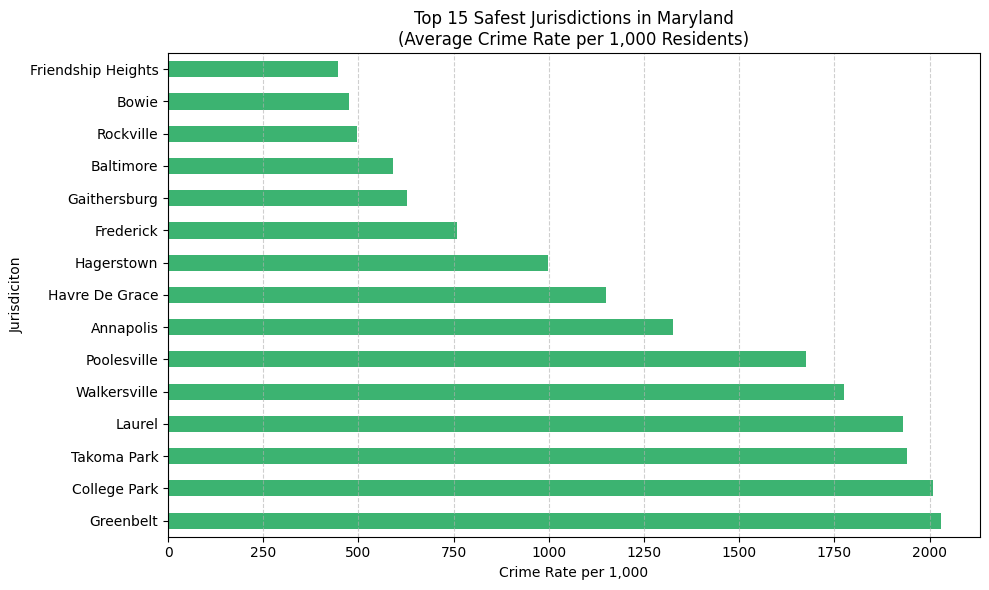

note, this includes non lethal crime and minor crimes
Hypothesis Test: Population in Top 15 Safest vs Others
T-statistic: 9.224
P-value: 0.00000 (rounded)


In [8]:
crime_start_idx = df.columns.get_loc("POPULATION") + 1
crime_cols = df.columns[crime_start_idx:]

crime_cols = [col for col in crime_cols if pd.api.types.is_numeric_dtype(df[col])]

# Compute crime rate
df["TOTAL CRIME"] = df[crime_cols].sum(axis=1)

# Compute crime rate per 1,000 people
df["Crime Rate per 1,000"] = df["TOTAL CRIME"] / df["POPULATION"] * 1000

avg_crime_rate = df.groupby("JURISDICTION")["Crime Rate per 1,000"].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_crime_rate.head(15).plot(kind="barh", color="mediumseagreen") #head shows lowest tail shows highest
plt.title("Top 15 Safest Jurisdictions in Maryland\n(Average Crime Rate per 1,000 Residents)")
plt.xlabel("Crime Rate per 1,000")
plt.ylabel("Jurisdiciton")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

safe_jurisdictions = avg_crime_rate.head(15).index
pop_safe = df[df['JURISDICTION'].isin(safe_jurisdictions)]['POPULATION']

# Other jurisdictions
pop_other = df[~df['JURISDICTION'].isin(safe_jurisdictions)]['POPULATION']

t_stat, p_val = ttest_ind(pop_safe, pop_other, equal_var=False)

print("note, this includes non lethal crime and minor crimes")
print("Hypothesis Test: Population in Top 15 Safest vs Others")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}", "(rounded)")

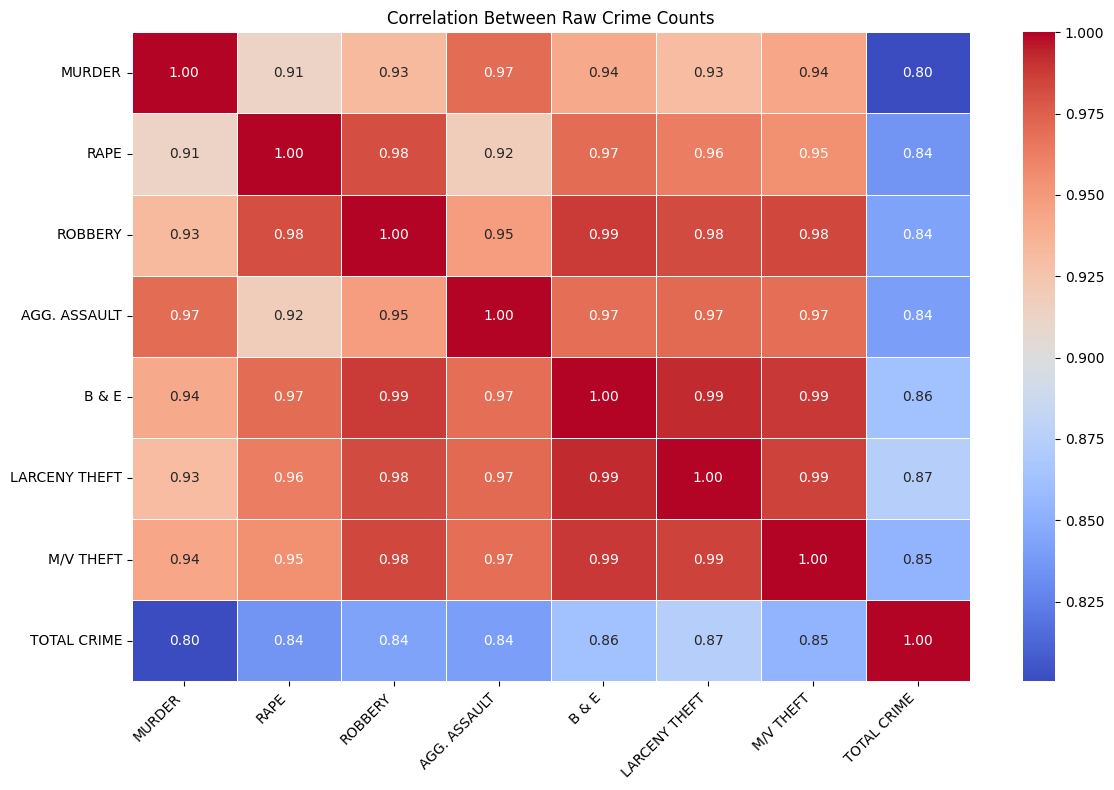

Total unique crime pairs compared: 28
Average t-statistic across all unique crime type pairs: -13.877
Average p-value across all unique crime type pairs: 0.05234


In [7]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

exclude_cols = ["GRAND TOTAL CRIME", "VIOLENT CRIME TOTAL","GRAND TOTAL"]

# Filter raw crime columns
raw_crime_cols = [
    col for col in df.columns
    if (col not in ["JURISDICTION", "COUNTY", "YEAR", "POPULATION"] + exclude_cols) and
       pd.api.types.is_numeric_dtype(df[col]) and
       "PER" not in col.upper() and
       "RATE" not in col.upper()
]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[raw_crime_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Raw Crime Counts")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

t_stats = []
p_values = []

for i in range(len(raw_crime_cols)):
    for j in range(i + 1, len(raw_crime_cols)):
        col1 = raw_crime_cols[i]
        col2 = raw_crime_cols[j]

        subset = df[[col1, col2]].dropna()

        if len(subset) > 2:
            t_stat, p_val = ttest_ind(subset[col1], subset[col2], equal_var=False)
            t_stats.append(t_stat)
            p_values.append(p_val)

avg_t_stat = np.mean(t_stats)
avg_p_value = np.mean(p_values)

print(f"Total unique crime pairs compared: {len(p_values)}")
print(f"Average t-statistic across all unique crime type pairs: {avg_t_stat:.3f}")
print(f"Average p-value across all unique crime type pairs: {avg_p_value:.5f}")


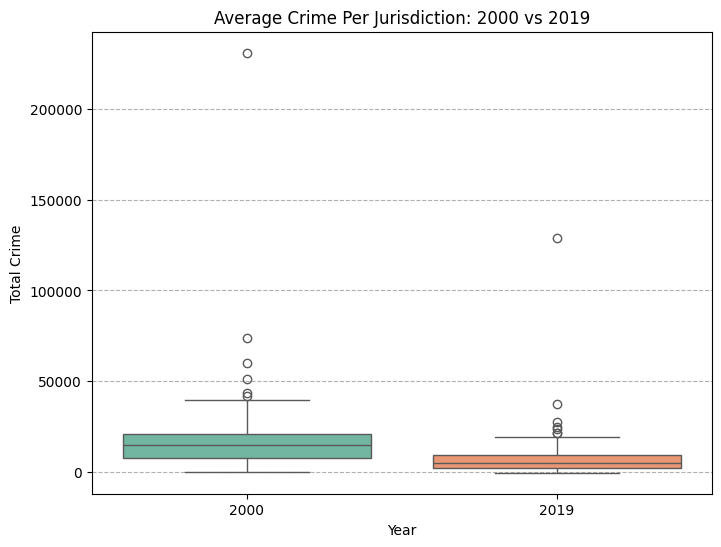

Comparing Total Crime per Jurisdiction Between 2000 and 2019
T-statistic: 4.900
P-value: 0.00000 (rounded)


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# combine into one DataFrame
combined_df = pd.concat([
    crime_2000.to_frame().assign(Year="2000"),
    crime_2019.to_frame().assign(Year="2019")
])

plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x="Year", y="TOTAL CRIME", hue="Year", palette="Set2")
plt.title("Average Crime Per Jurisdiction: 2000 vs 2019")
plt.ylabel("Total Crime")
plt.grid(True, linestyle='--', axis='y')

plt.legend([], [], frameon=False)

plt.show()

t_stat, p_val = ttest_ind(crime_2000, crime_2019, equal_var=False)

# Print hypothesis testing
print("Comparing Total Crime per Jurisdiction Between 2000 and 2019")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}", "(rounded)")
